<a href="https://colab.research.google.com/github/sbogde/scikit-regressions-and-confessions/blob/main/week3_06_svr_kc_houses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
# Check if running in Google Colab (ensure the notebook is file-system agnostic)
if 'google.colab' in str(get_ipython()):
    from google.colab import drive, data_table
    drive.mount('/content/drive')
    file_path = '/content/drive/My Drive/Colab Notebooks/kc_house_data.csv'
    data_table.enable_dataframe_formatter()
else:
    file_path = './kc_house_data.csv'  # Local path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Read the dataset from the specified file path into a pandas DataFrame
data = pd.read_csv(file_path)

In [6]:
# Display the first 5 rows of the dataset to understand its structure and content
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
0,221900.0,3,1.00,1180,5650,1.0,7,1180,0,1955,0,47.5112,-122.257,1340,5650,3
1,538000.0,3,2.25,2570,7242,2.0,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,3
2,180000.0,2,1.00,770,10000,1.0,6,770,0,1933,0,47.7379,-122.233,2720,8062,3
3,604000.0,4,3.00,1960,5000,1.0,7,1050,910,1965,0,47.5208,-122.393,1360,5000,5
4,510000.0,3,2.00,1680,8080,1.0,8,1680,0,1987,0,47.6168,-122.045,1800,7503,3


In [7]:
# Check and handle missing values:
data.isnull().sum()

,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
grade,0
sqft_above,0
sqft_basement,0
yr_built,0


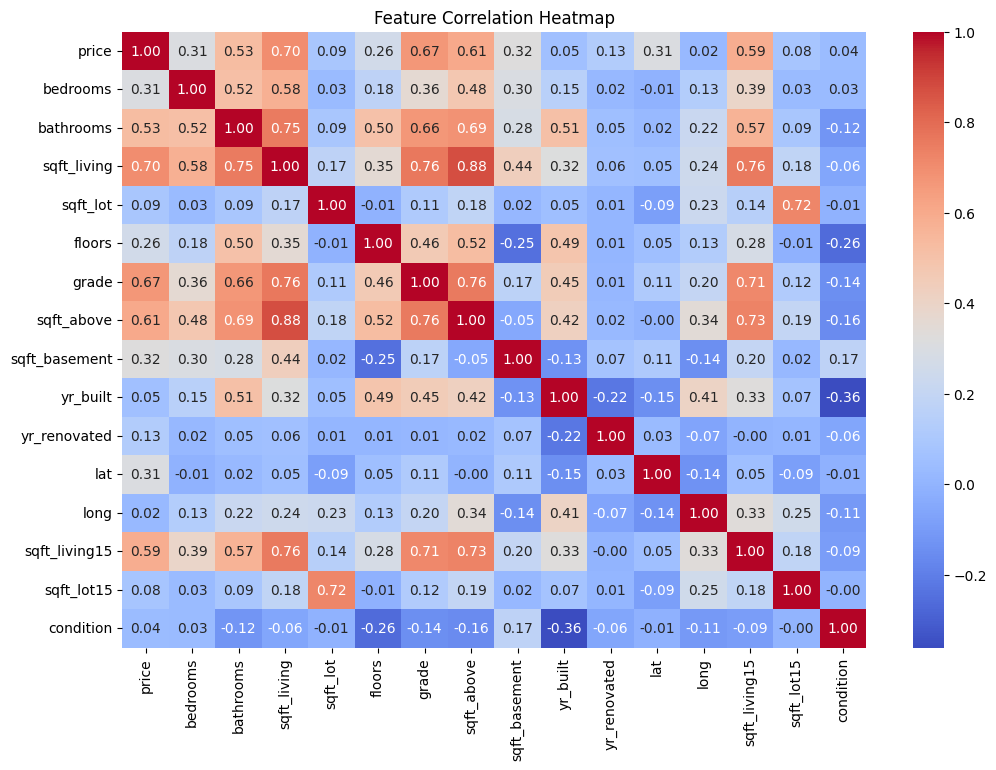

In [20]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") # 'fmt=".2f"' ensures values are shown with 2 decimals for consistency
plt.title("Feature Correlation Heatmap")
plt.show()

In [25]:
data.corr()['price'].sort_values(ascending=False)

,price
price,1.000000
sqft_living,0.702044
grade,0.667463
sqft_above,0.605566
sqft_living15,0.585374
bathrooms,0.525134
sqft_basement,0.323837
bedrooms,0.308338
lat,0.306919
floors,0.256786


In [23]:
import plotly.express as px

# dataplus = data[np.logical_and(data.grade >= 7,data.yr_built >= 2000)]
dataplus = data
#list lat and long
lats = list(dataplus.lat.values)
longs = list(dataplus.long.values)

fig = px.scatter_mapbox(lat=lats, lon=longs, zoom=10, height=500)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [9]:
# Drop irrelevant or weakly correlated features
# X = data.drop(columns=['id', 'date', 'price', 'zipcode', 'sqft_lot'])
X = data.drop(columns=['price', 'sqft_lot', 'sqft_lot15', 'lat', 'long'])

y = data['price']  # Target variable

In [10]:
# One-Hot Encode categorical columns
X = pd.get_dummies(X, columns=['condition', 'grade'], drop_first=True)

# Check the resulting dataset
print(X.head())


   bedrooms  bathrooms  sqft_living  floors  sqft_above  sqft_basement  \
0         3       1.00         1180     1.0        1180              0   
1         3       2.25         2570     2.0        2170            400   
2         2       1.00          770     1.0         770              0   
3         4       3.00         1960     1.0        1050            910   
4         3       2.00         1680     1.0        1680              0   

   yr_built  yr_renovated  sqft_living15  condition_2  ...  grade_4  grade_5  \
0      1955             0           1340        False  ...    False    False   
1      1951          1991           1690        False  ...    False    False   
2      1933             0           2720        False  ...    False    False   
3      1965             0           1360        False  ...    False    False   
4      1987             0           1800        False  ...    False    False   

   grade_6  grade_7  grade_8  grade_9  grade_10  grade_11  grade_12  grade

In [11]:
from sklearn.preprocessing import StandardScaler

# Initialise the scaler
scaler = StandardScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)


In [12]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [13]:

# Initialise SVR with RBF kernel
# regressor = SVR(kernel='rbf', C=100, epsilon=0.1) 0.08
# regressor = SVR(kernel='linear') 0.07
# regressor = SVR(kernel='poly') 0.004
# regressor = SVR(kernel='sigmoid') -0.059
# regressor = SVR(kernel='rbf', C=1000) #0.3128
# regressor = SVR(kernel='rbf', C=10000) #0.478
# regressor = SVR(kernel='rbf', C=50000) #0.578
# regressor = SVR(kernel='rbf', C=1000000) #0.663
regressor = SVR(kernel='rbf', C=1050000) #0.663
# regressor = SVR(kernel='rbf', C=1100000) #0.663
# regressor = SVR(kernel='rbf', C=1500000) #0.660
# regressor = SVR(kernel='rbf', C=2500000) #0.652


# Fit the model
regressor.fit(X_train, y_train)

# Predict on test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")


MAE: 129750.76114724936
MSE: 50892235975.56059
R²: 0.6637551731841435


In [14]:
x = data.iloc[:,1:]
y = data.iloc[:,0:1]
X = x.values
Y = y.values
Y


array([[221900.],
       [538000.],
       [180000.],
       ...,
       [402101.],
       [400000.],
       [325000.]])

In [15]:
sc1=StandardScaler()
x_scaled = sc1.fit_transform(X)

sc2=StandardScaler()
y_scaled = np.ravel(sc2.fit_transform(Y.reshape(-1,1)))

In [16]:
sc1=StandardScaler()
x_scaled = sc1.fit_transform(X)

sc2=StandardScaler()
y_scaled = np.ravel(sc2.fit_transform(Y.reshape(-1,1)))

In [19]:
svr_reg = SVR(kernel='rbf') # 79.62
# svr_reg = SVR(kernel='rbf', C=5) # 87.16
# svr_reg = SVR(kernel='rbf', C=10) # 89.93
svr_reg.fit(x_scaled,y_scaled)

print(f'R² score: {r2_score(y_scaled, svr_reg.predict(x_scaled))*100}')

R² score: 87.1617243796408


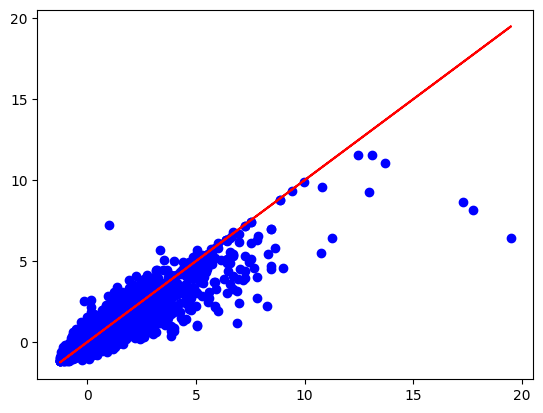

In [24]:
#SVR - Regression Graph
predictArray_svr = svr_reg.predict(x_scaled)
plt.scatter(y_scaled,predictArray_svr, color="b")
plt.plot(y_scaled,y_scaled, color="r")